In [1]:
import pennylane as qml
from qco_new import *
from qco_new_joint import optimizeJoint, optimizeJoint_aug

In [2]:
[ds] = qml.data.load("ketgpt")

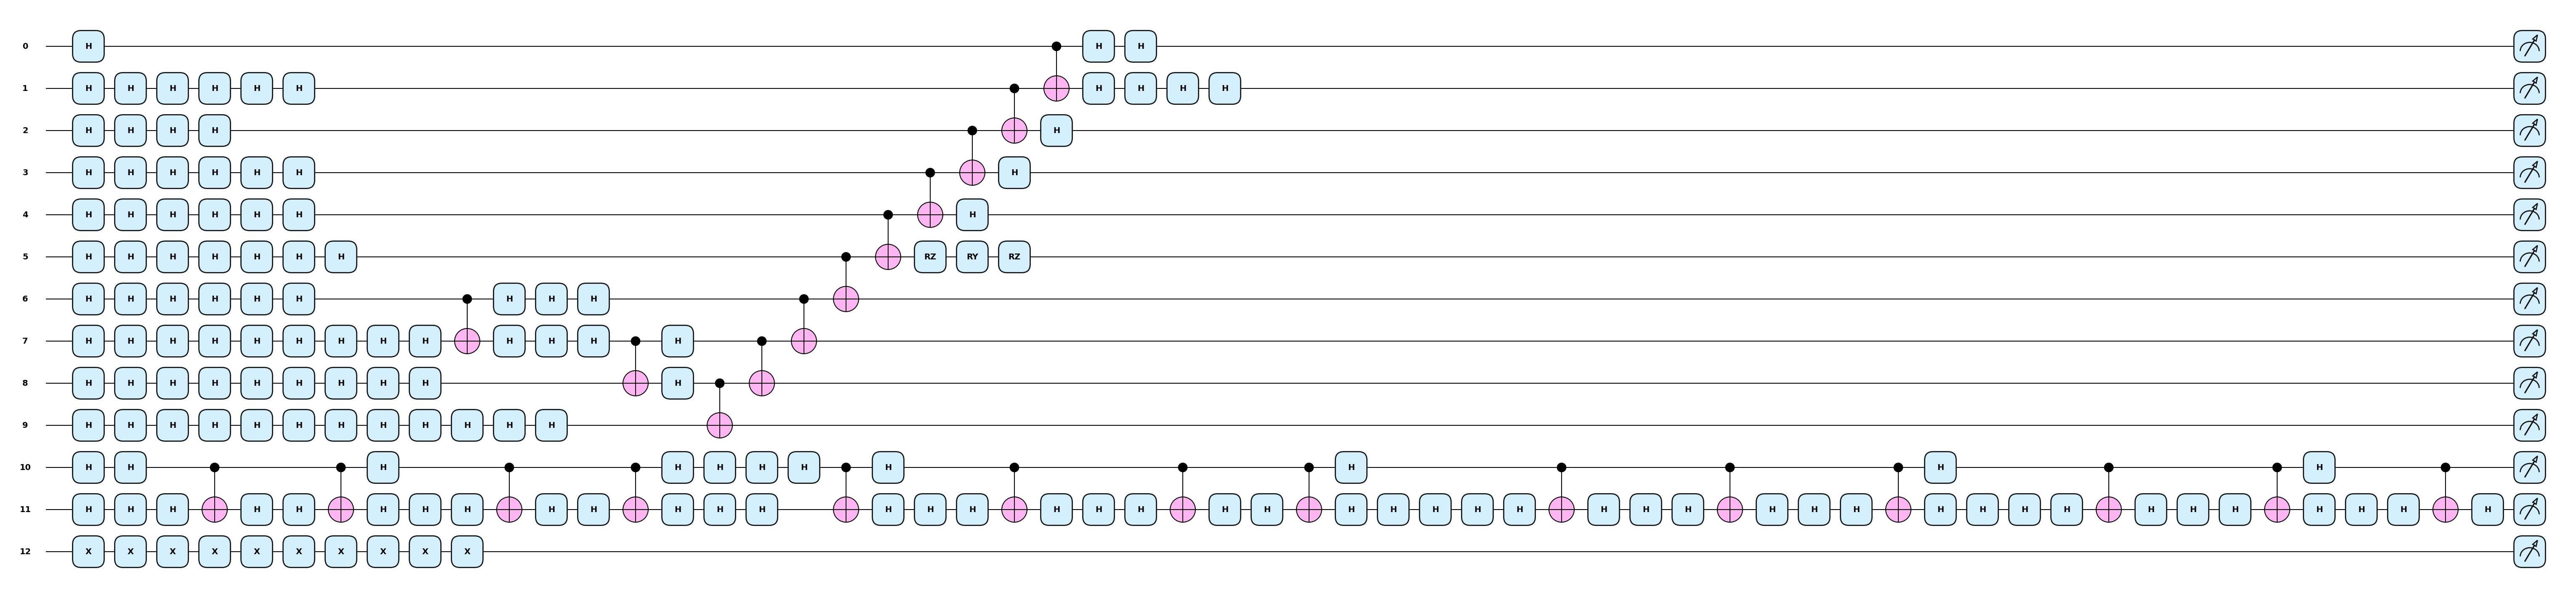

In [3]:
# example
seed = 0
@qml.qnode(qml.device('default.qubit'))
def circuit():
    for op in ds.circuits[seed]:
        name = op.name
        params = op.parameters
        wires = op.wires
        if name == 'QubitUnitary': # to remove the need of unitary synthesis
            continue
        elif name == 'CZ':
            qml.Hadamard(wires[1])
            qml.CNOT(wires)
            qml.Hadamard(wires[1])
        elif name == 'U1':
            qml.RZ(params[0], wires=wires)
        elif name == 'U2':
            qml.RZ(params[0], wires=wires)
            qml.RY(np.pi/2, wires=wires)
            qml.RZ(params[1], wires=wires)
        else:
            qml.apply(op)
    return qml.state()

show_circuit(circuit)

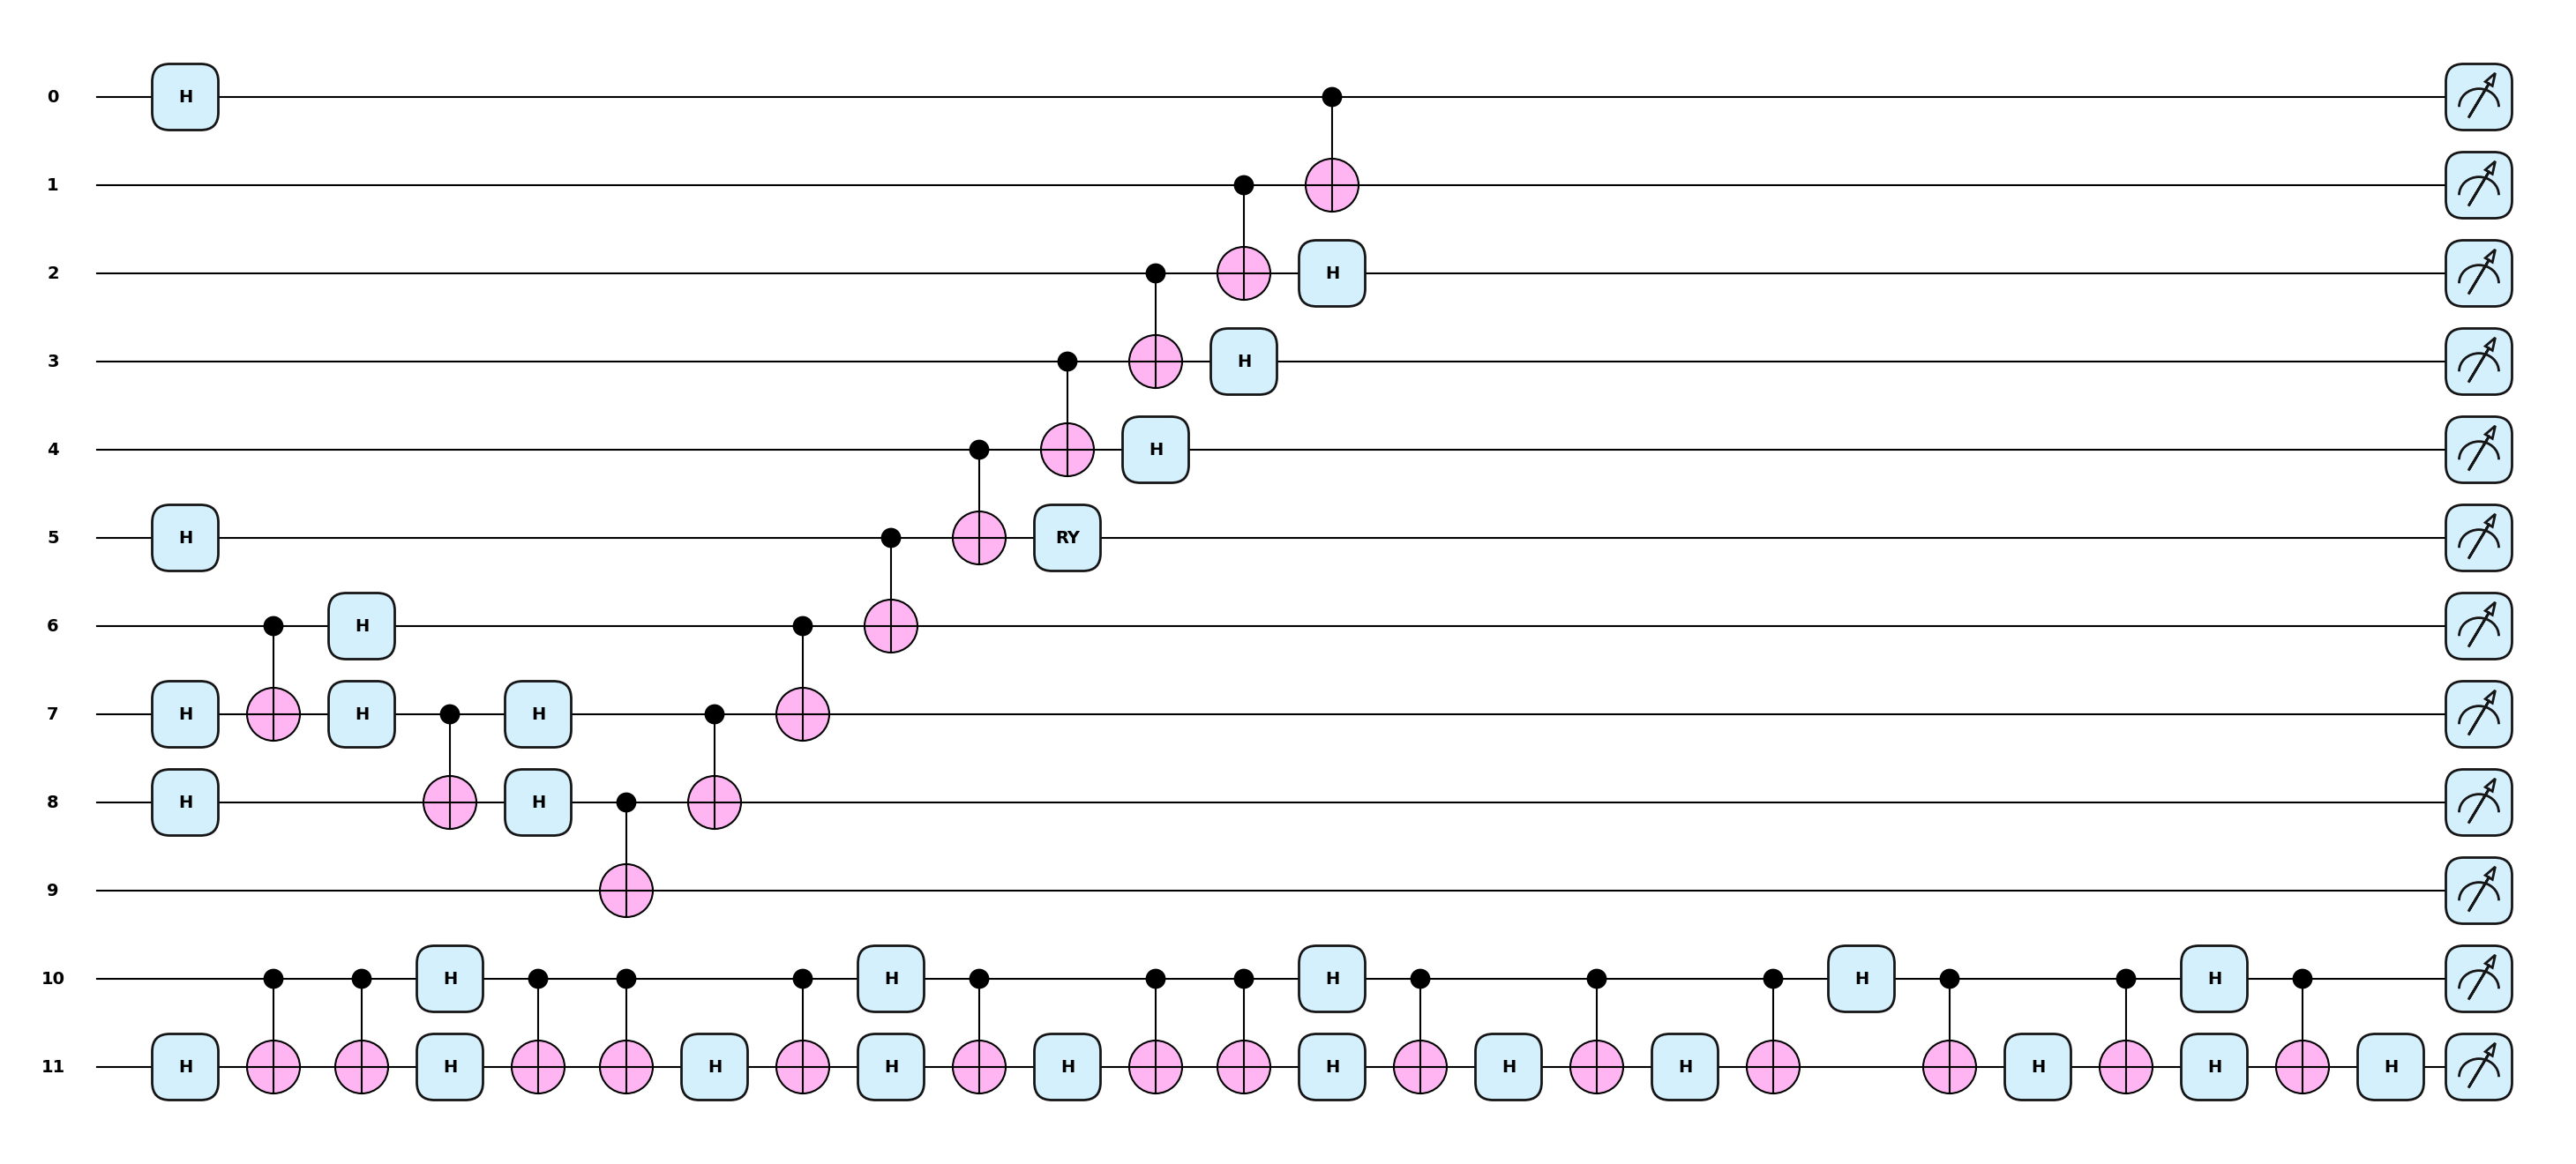

In [4]:
info1 = optimize1q(qnode=circuit)
show_info(info1)

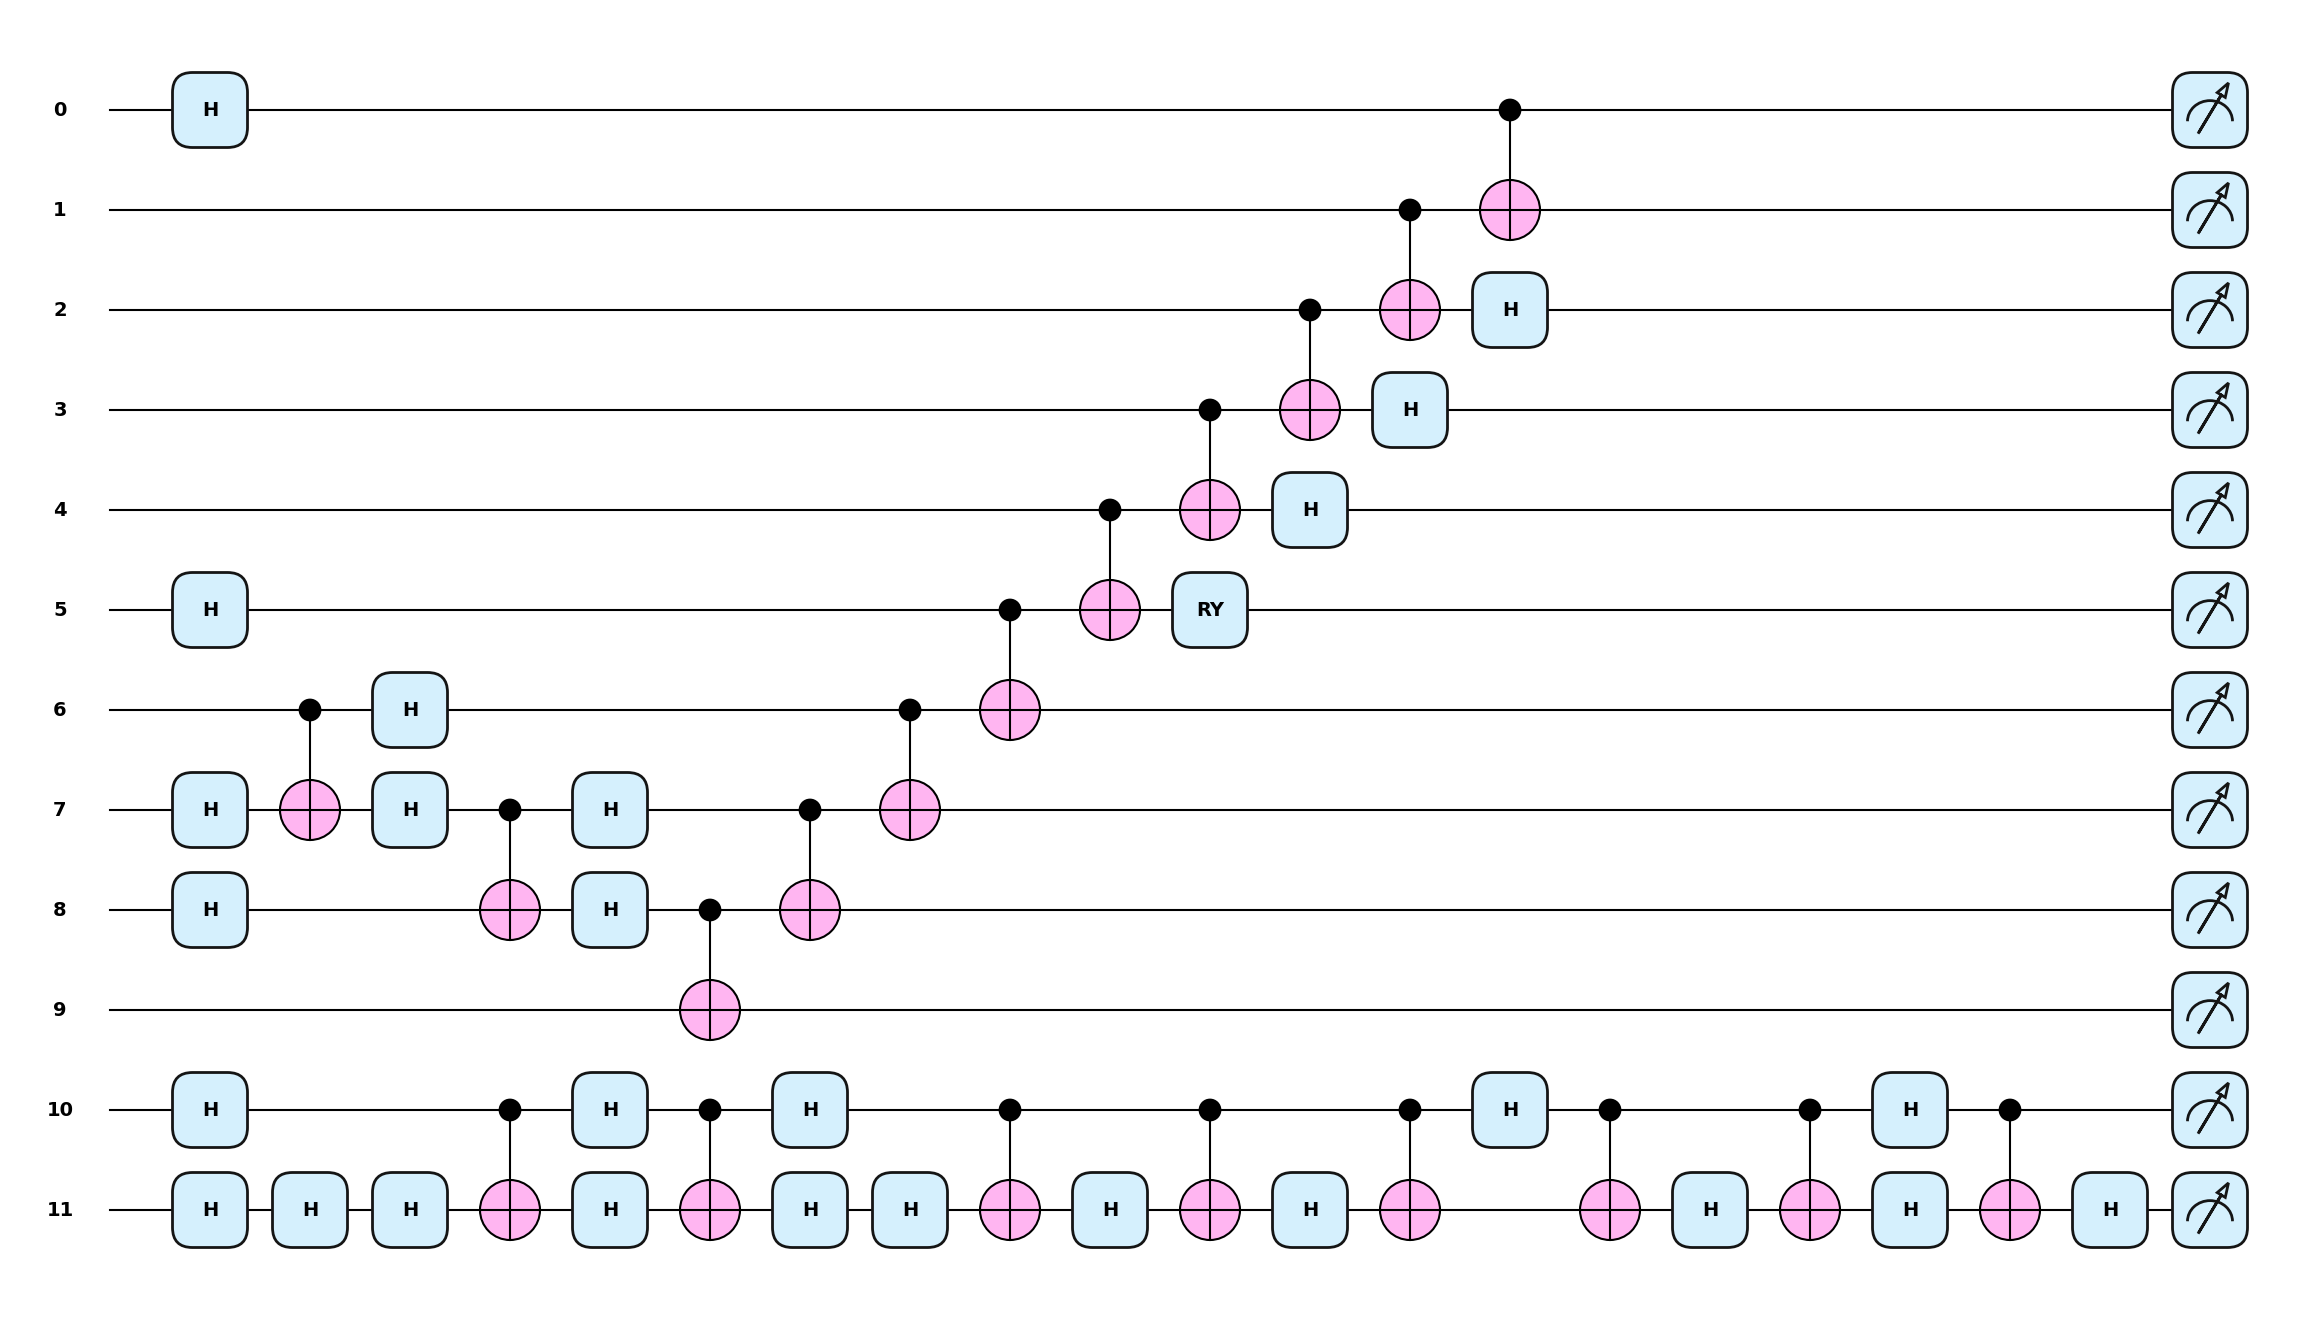

In [5]:
info2 = optimize2q(circuit_info=info1)
show_info(info2)

approach #1

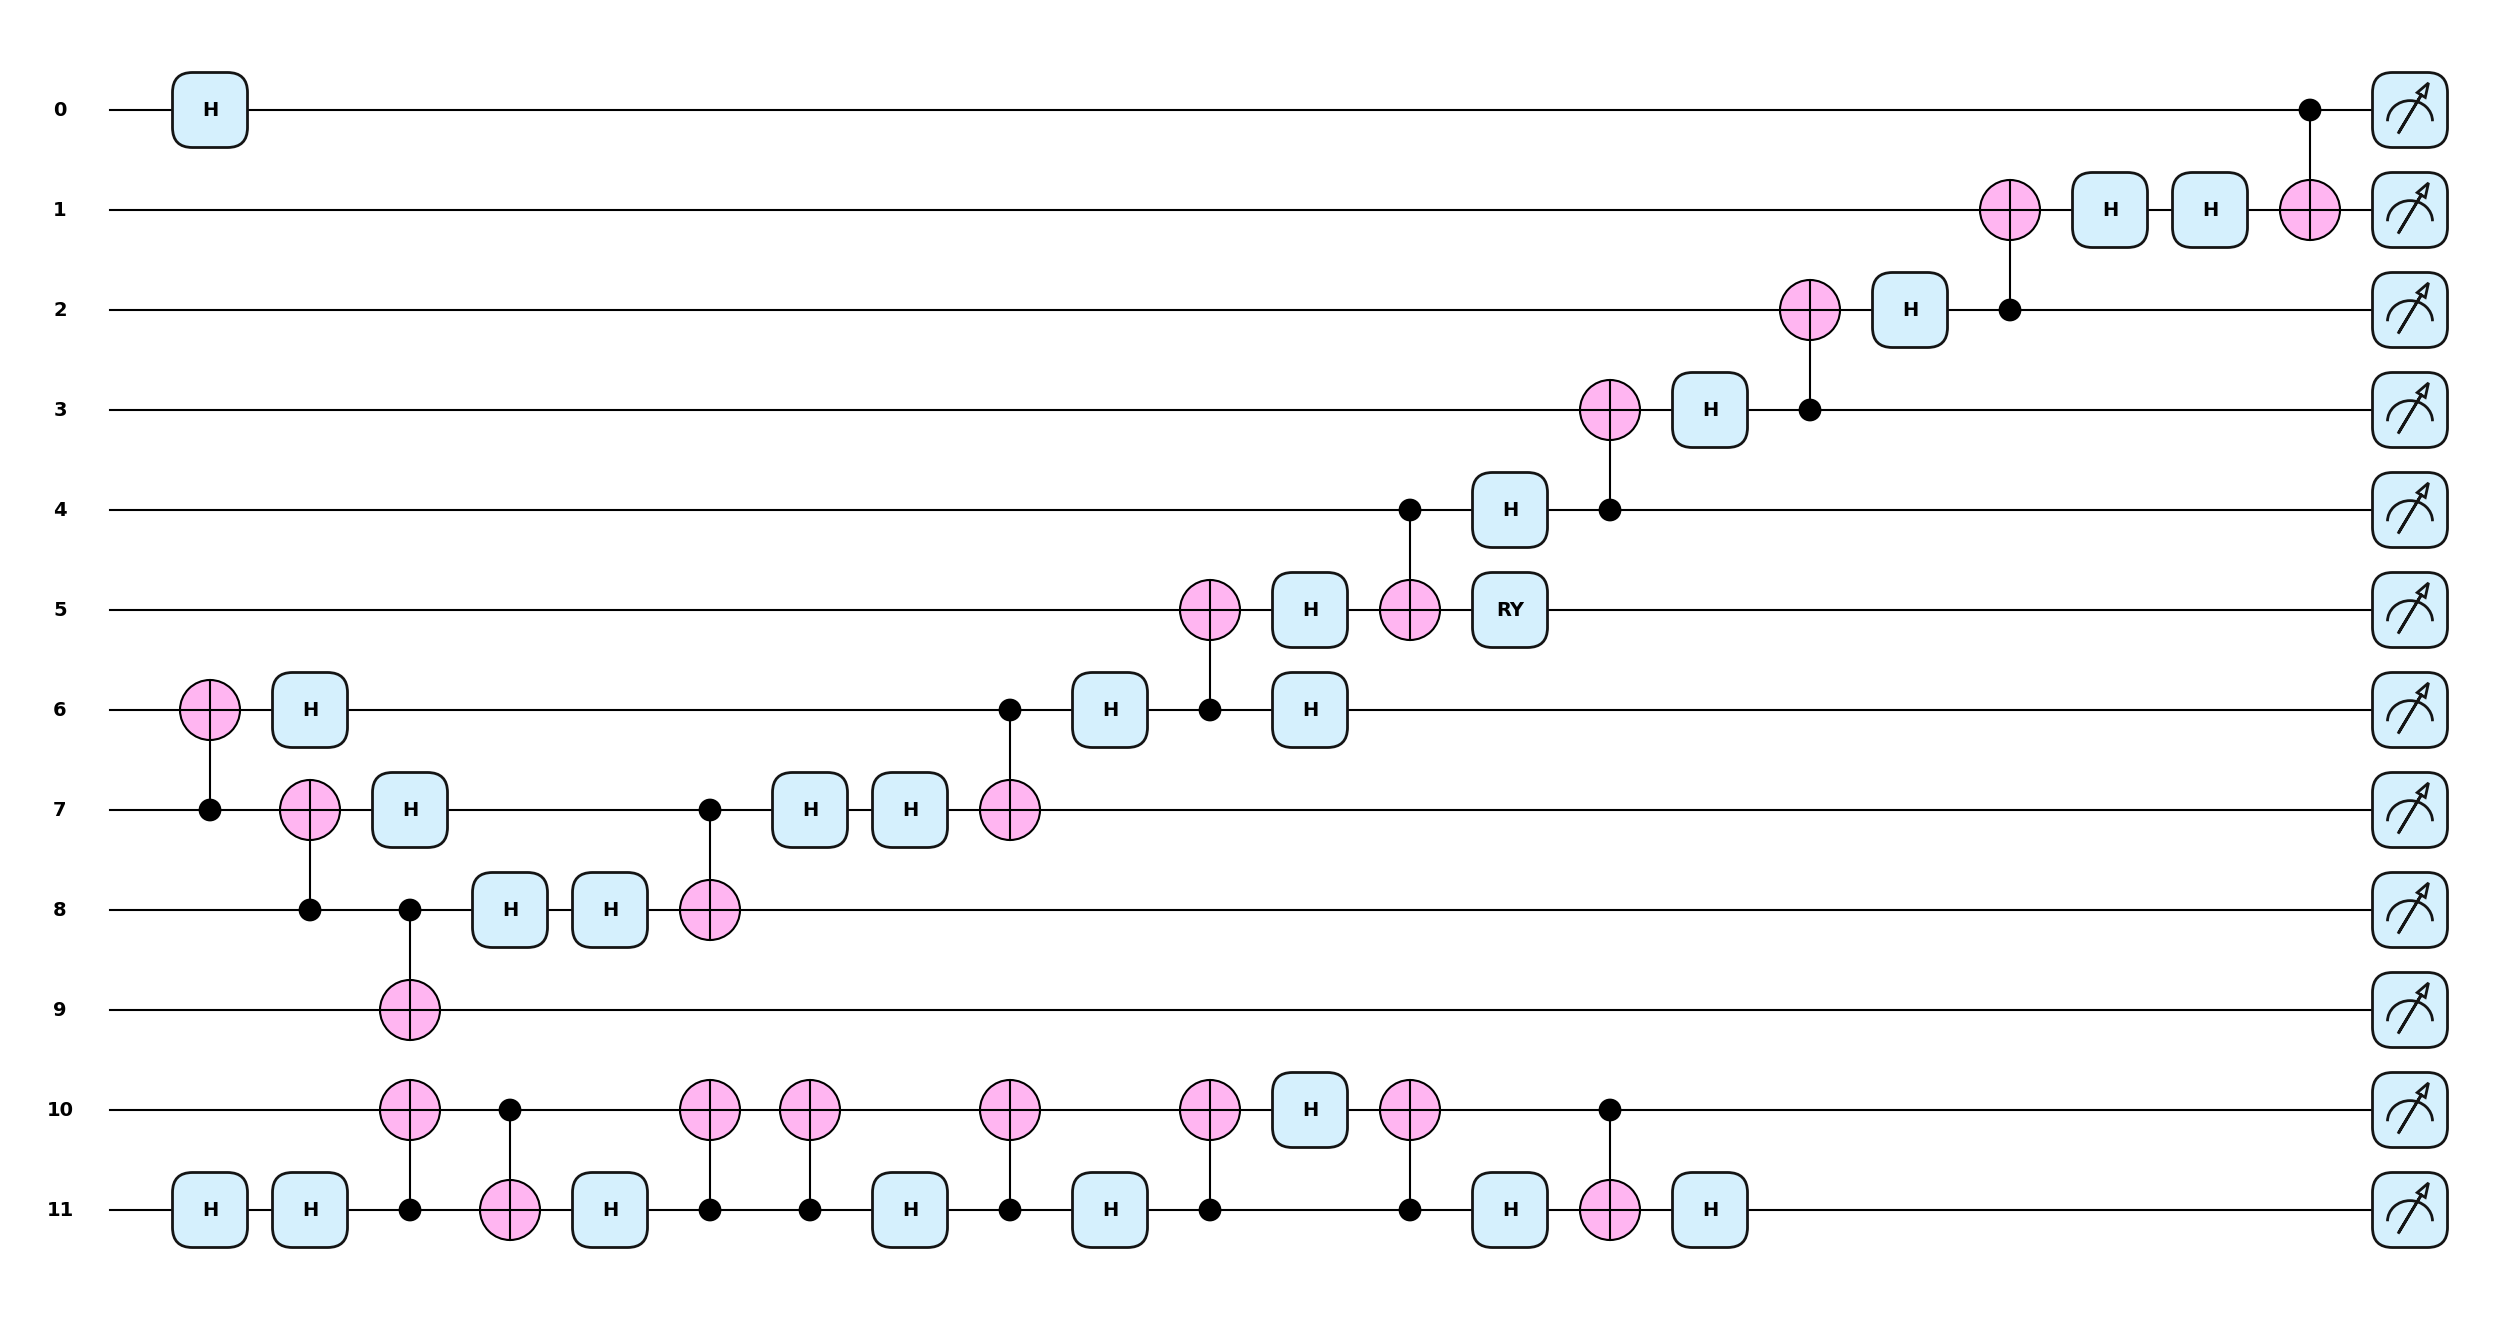

In [6]:
info3 = optimizeJoint_aug(circuit_info=info2)
show_info(info3)

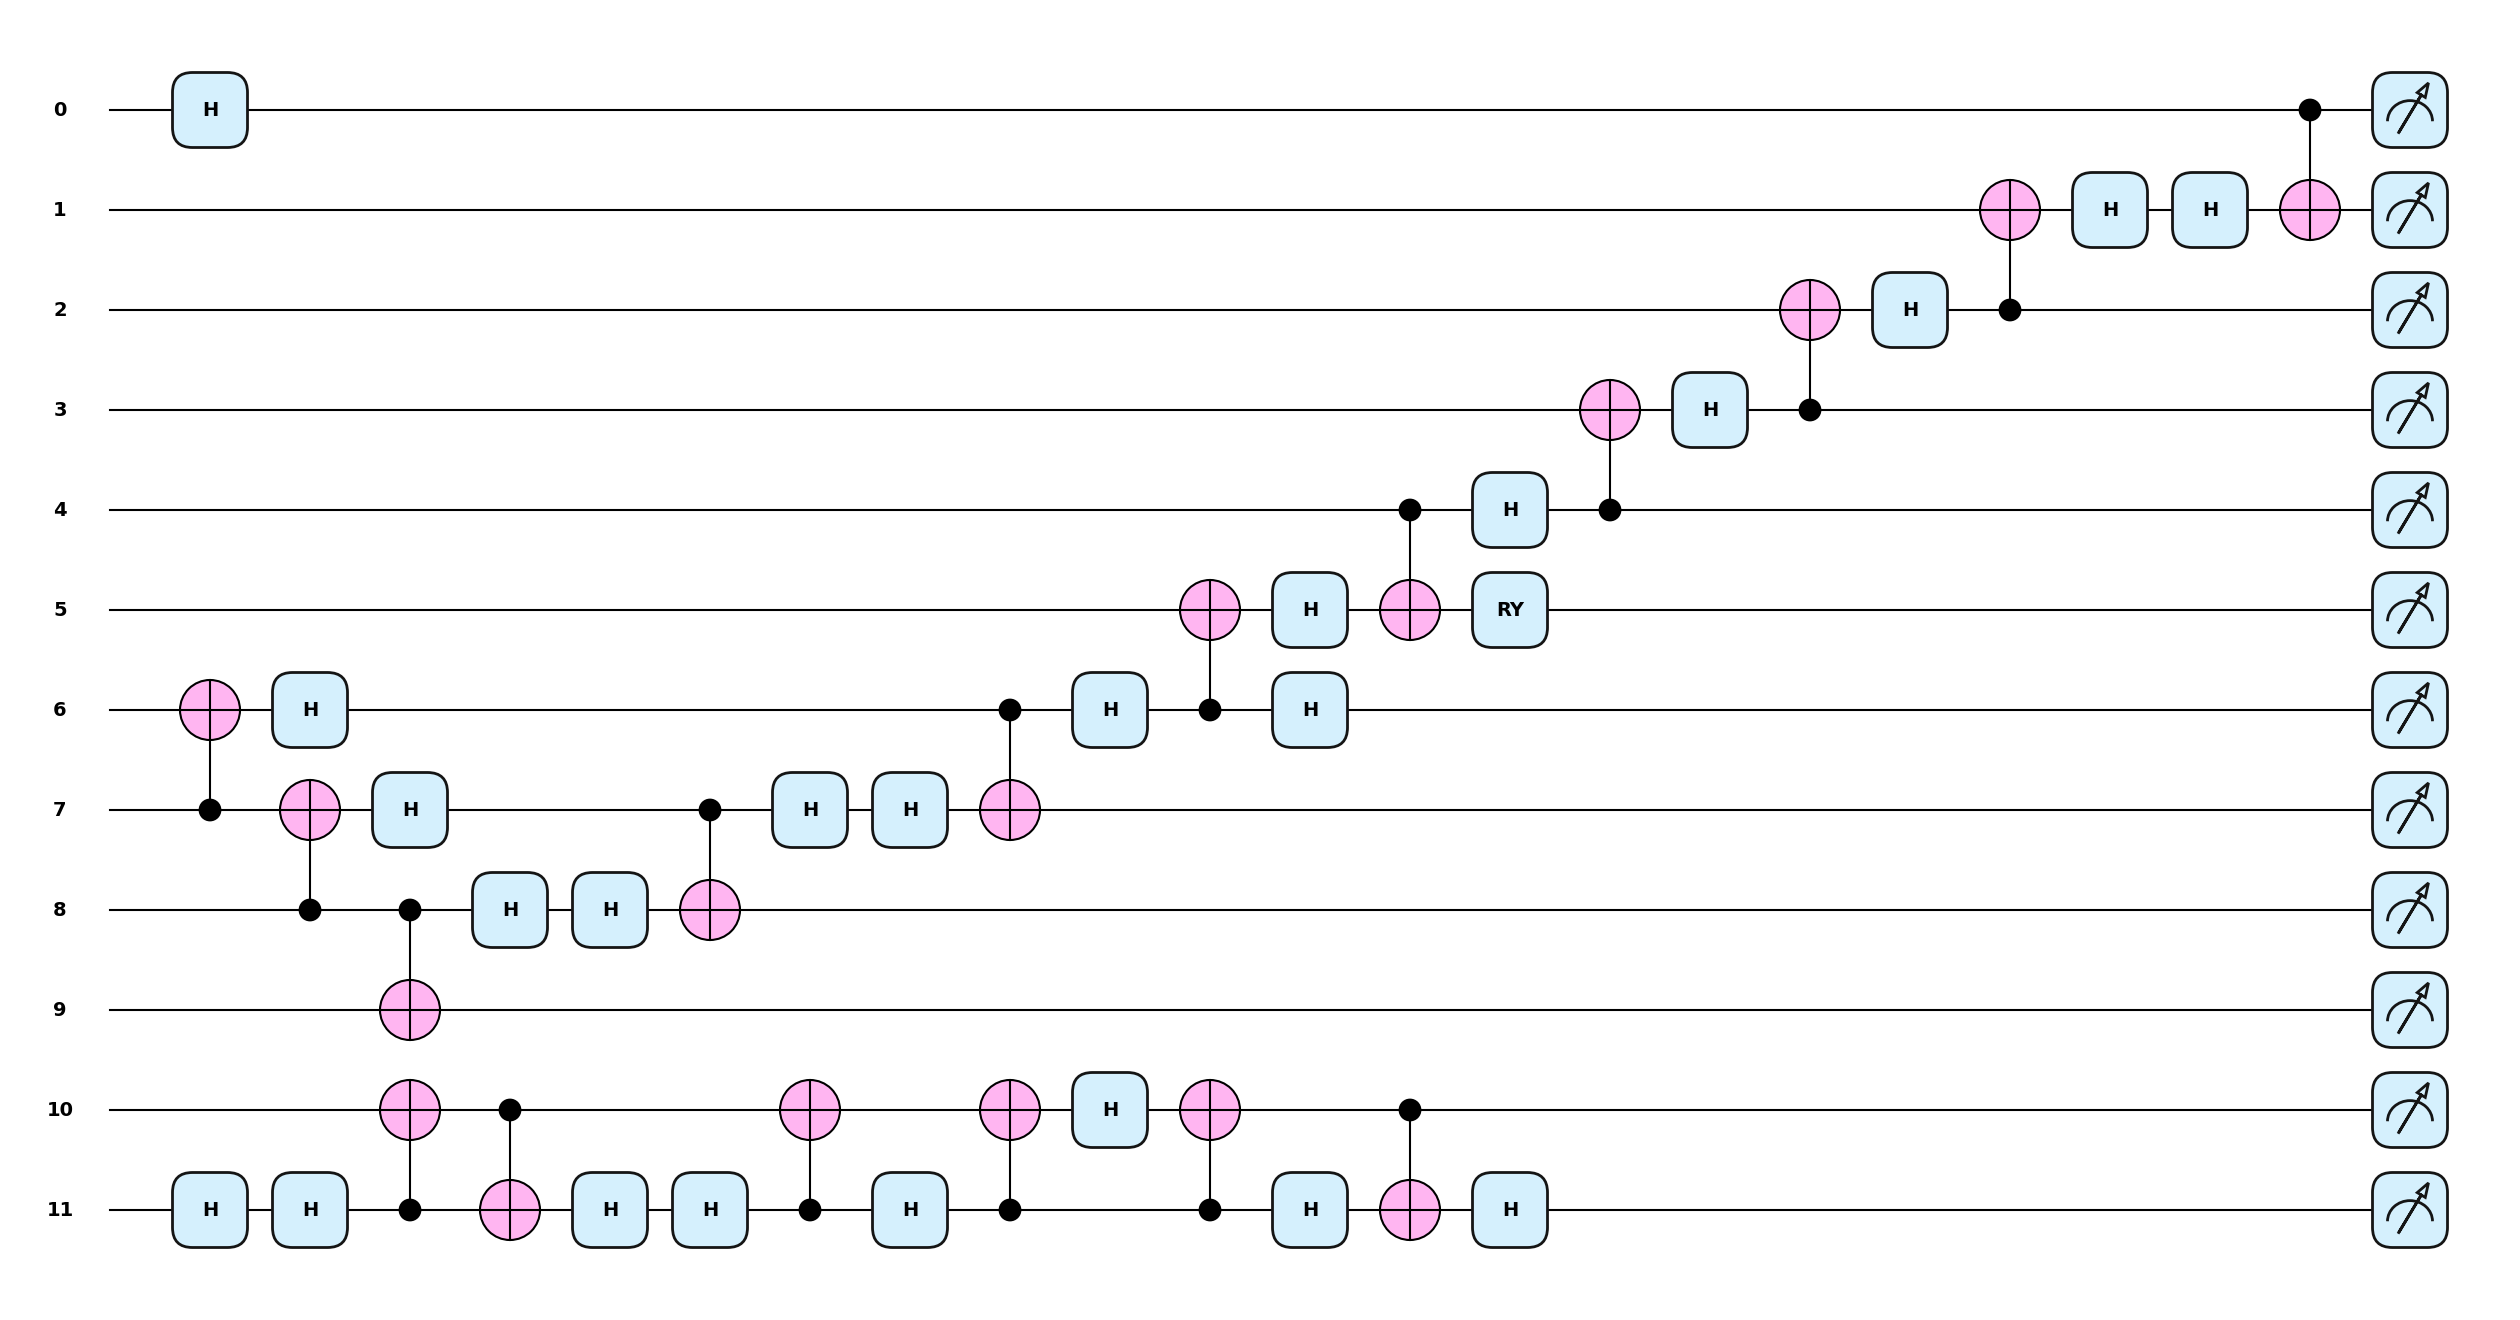

In [7]:
info4 = optimize2q(circuit_info=info3)
show_info(info4)

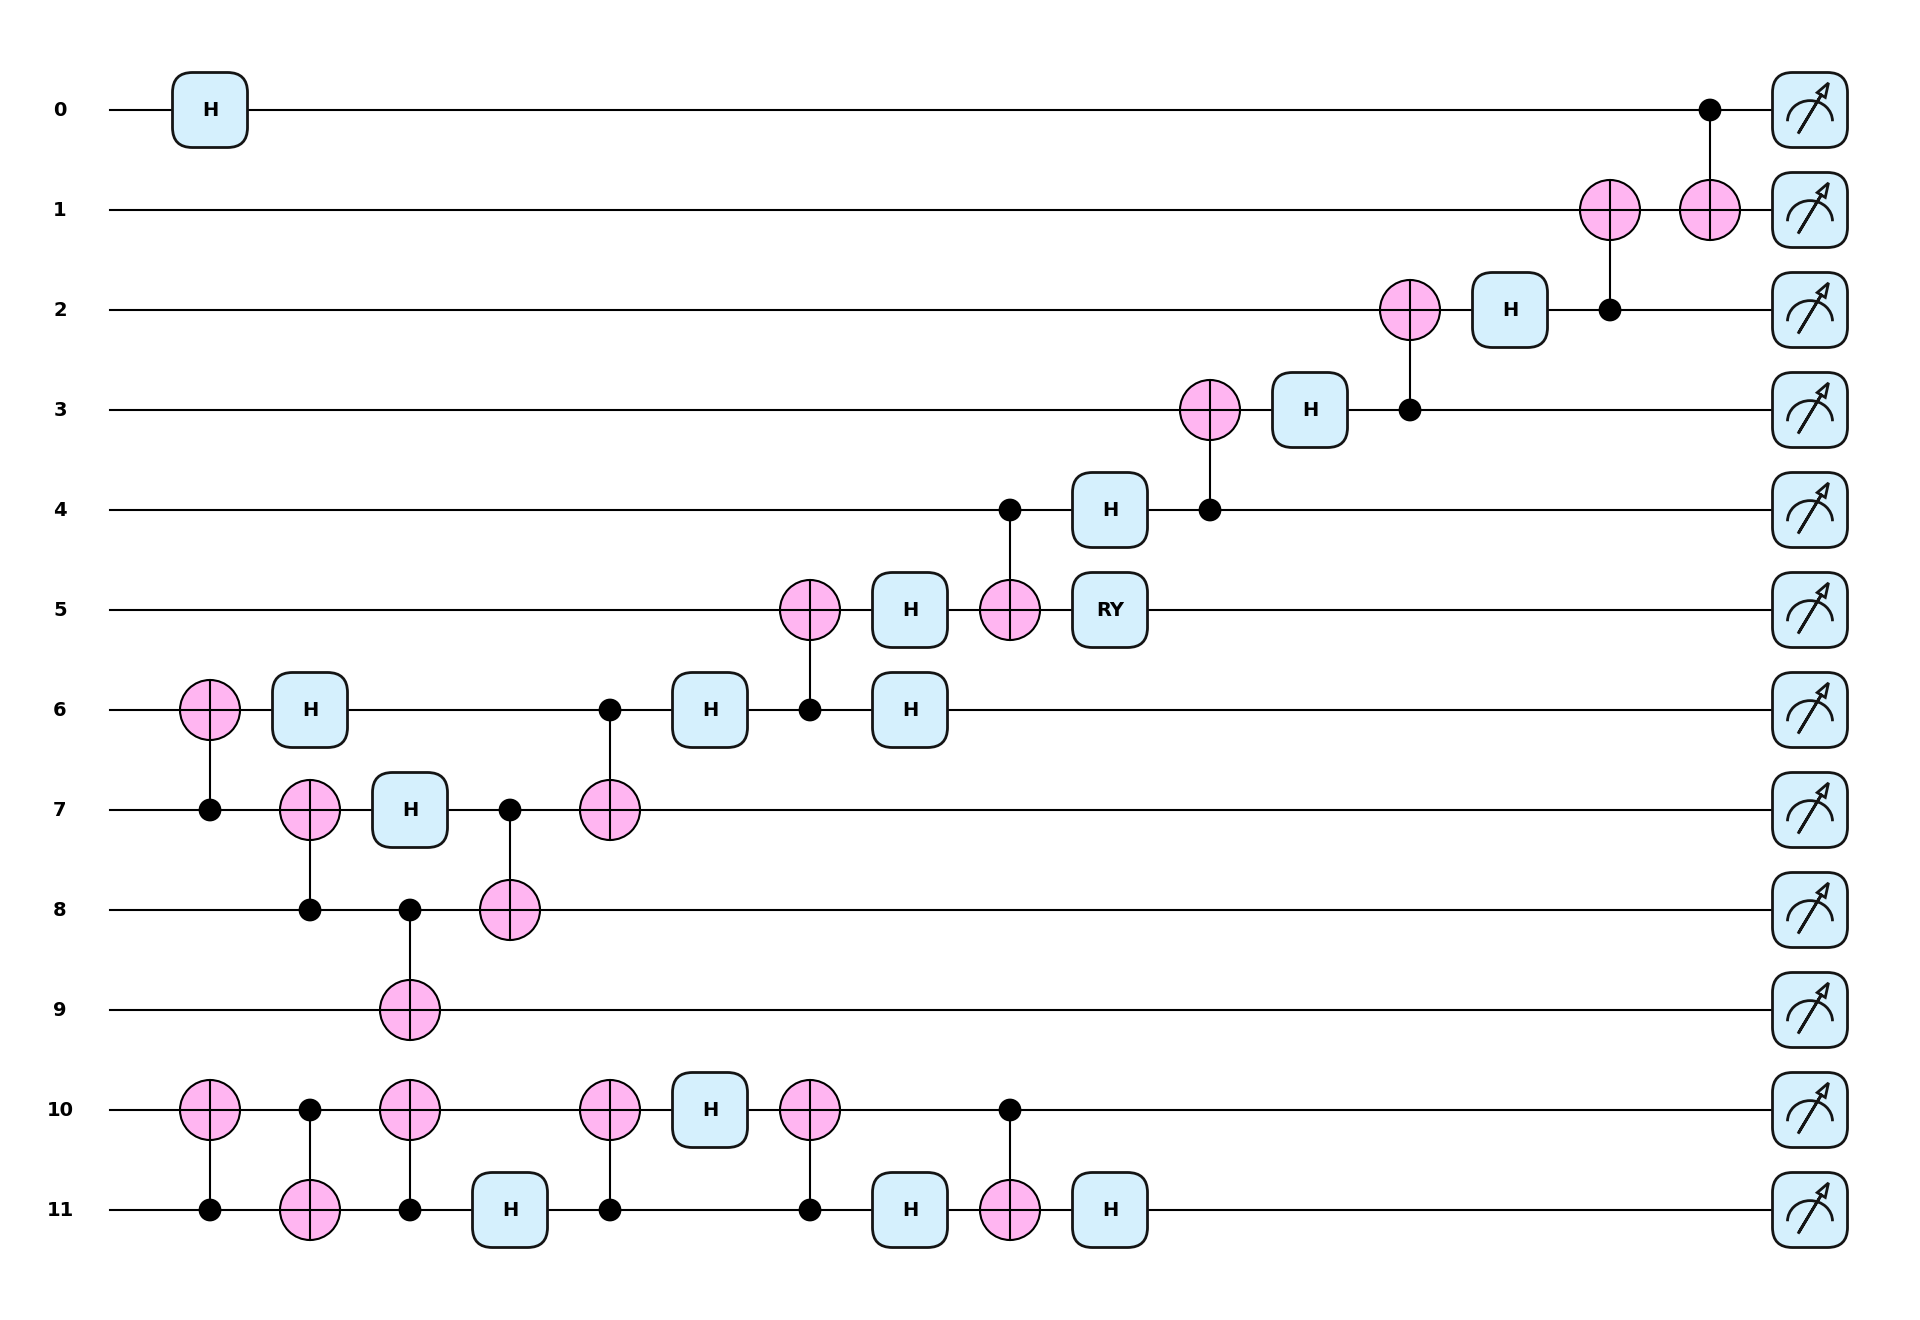

In [8]:
info5 = optimize1q(circuit_info=info4)
show_info(info5)

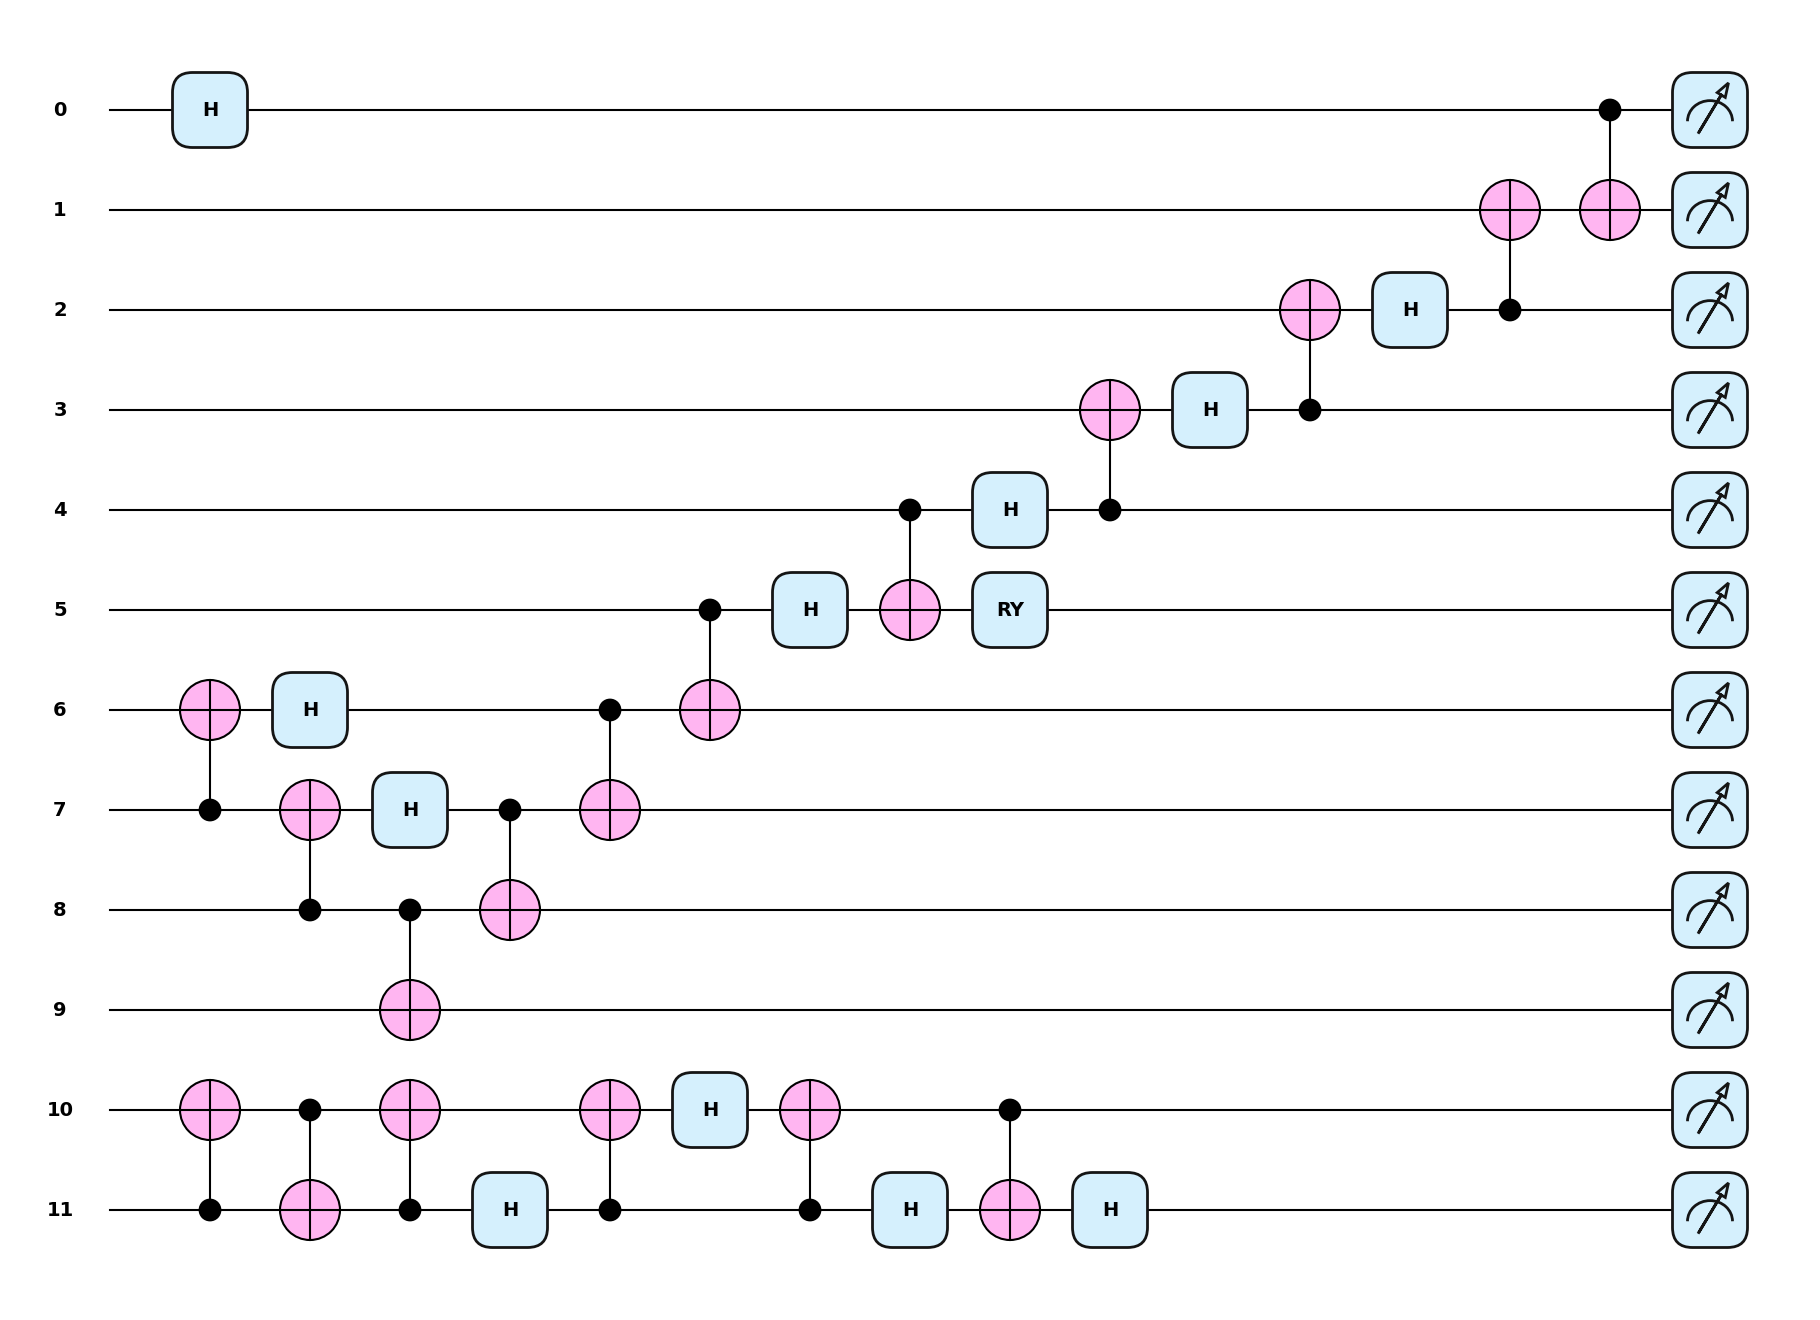

In [9]:
info6 = optimizeJoint(circuit_info=info5)
show_info(info6)

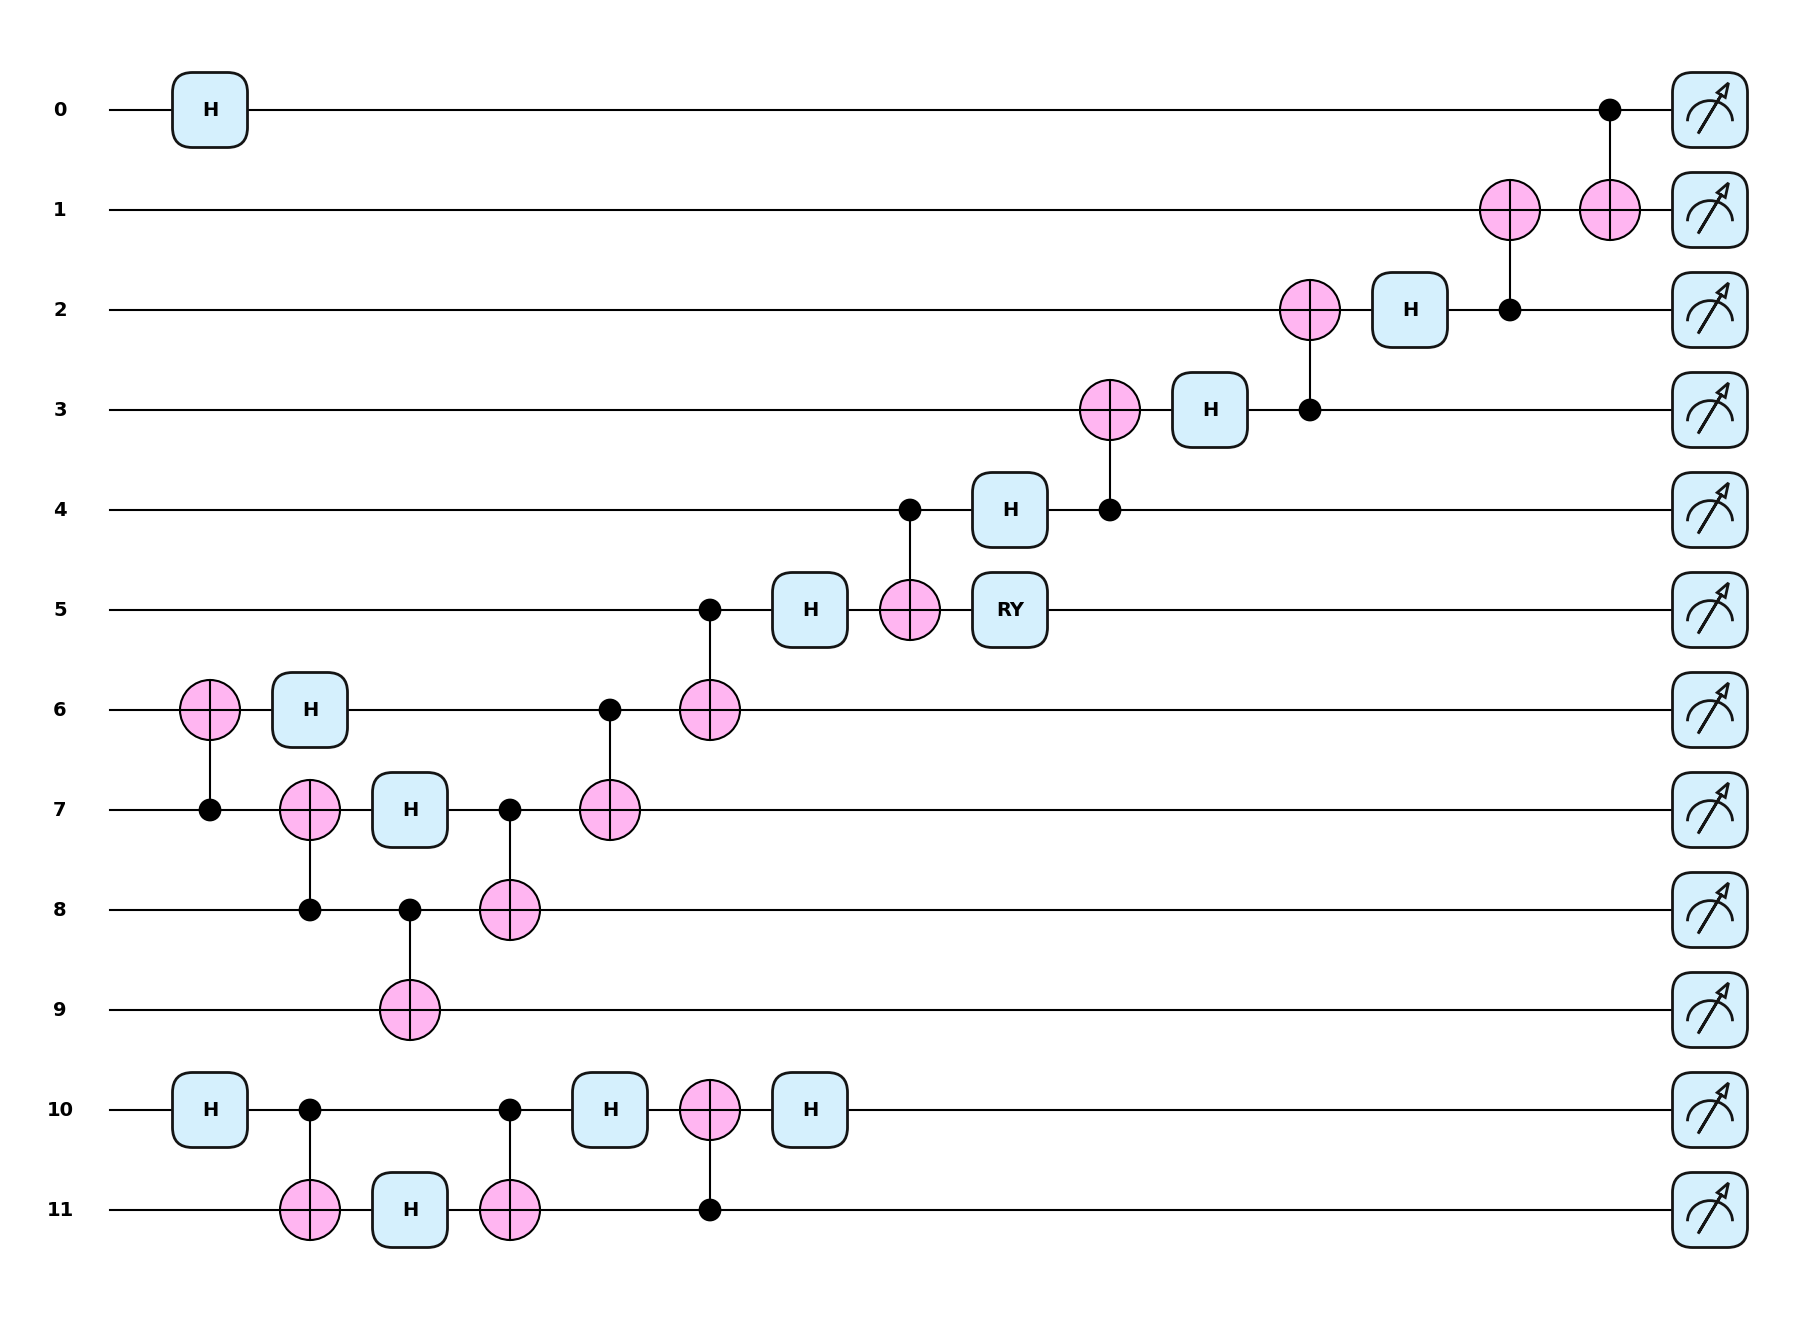

In [10]:
swap = [{'label': 'CNOT', 'params': [], 'wires': [11, 10]},
 {'label': 'CNOT', 'params': [], 'wires': [10, 11]},
 {'label': 'CNOT', 'params': [], 'wires': [11, 10]}]
for g in swap:
    info6.remove(g)

def swap_wires(circuit_info, w1, w2):
    new_circuit = []
    for gate in circuit_info:
        new_wires = []
        for w in gate["wires"]:
            if w == w1:
                new_wires.append(w2)
            elif w == w2:
                new_wires.append(w1)
            else:
                new_wires.append(w)
        new_gate = {
            "label": gate["label"],
            "params": gate["params"],
            "wires": new_wires
        }
        new_circuit.append(new_gate)
    return new_circuit

info7 = swap_wires(info6, 10, 11)
show_info(info7)

other frameworks

2


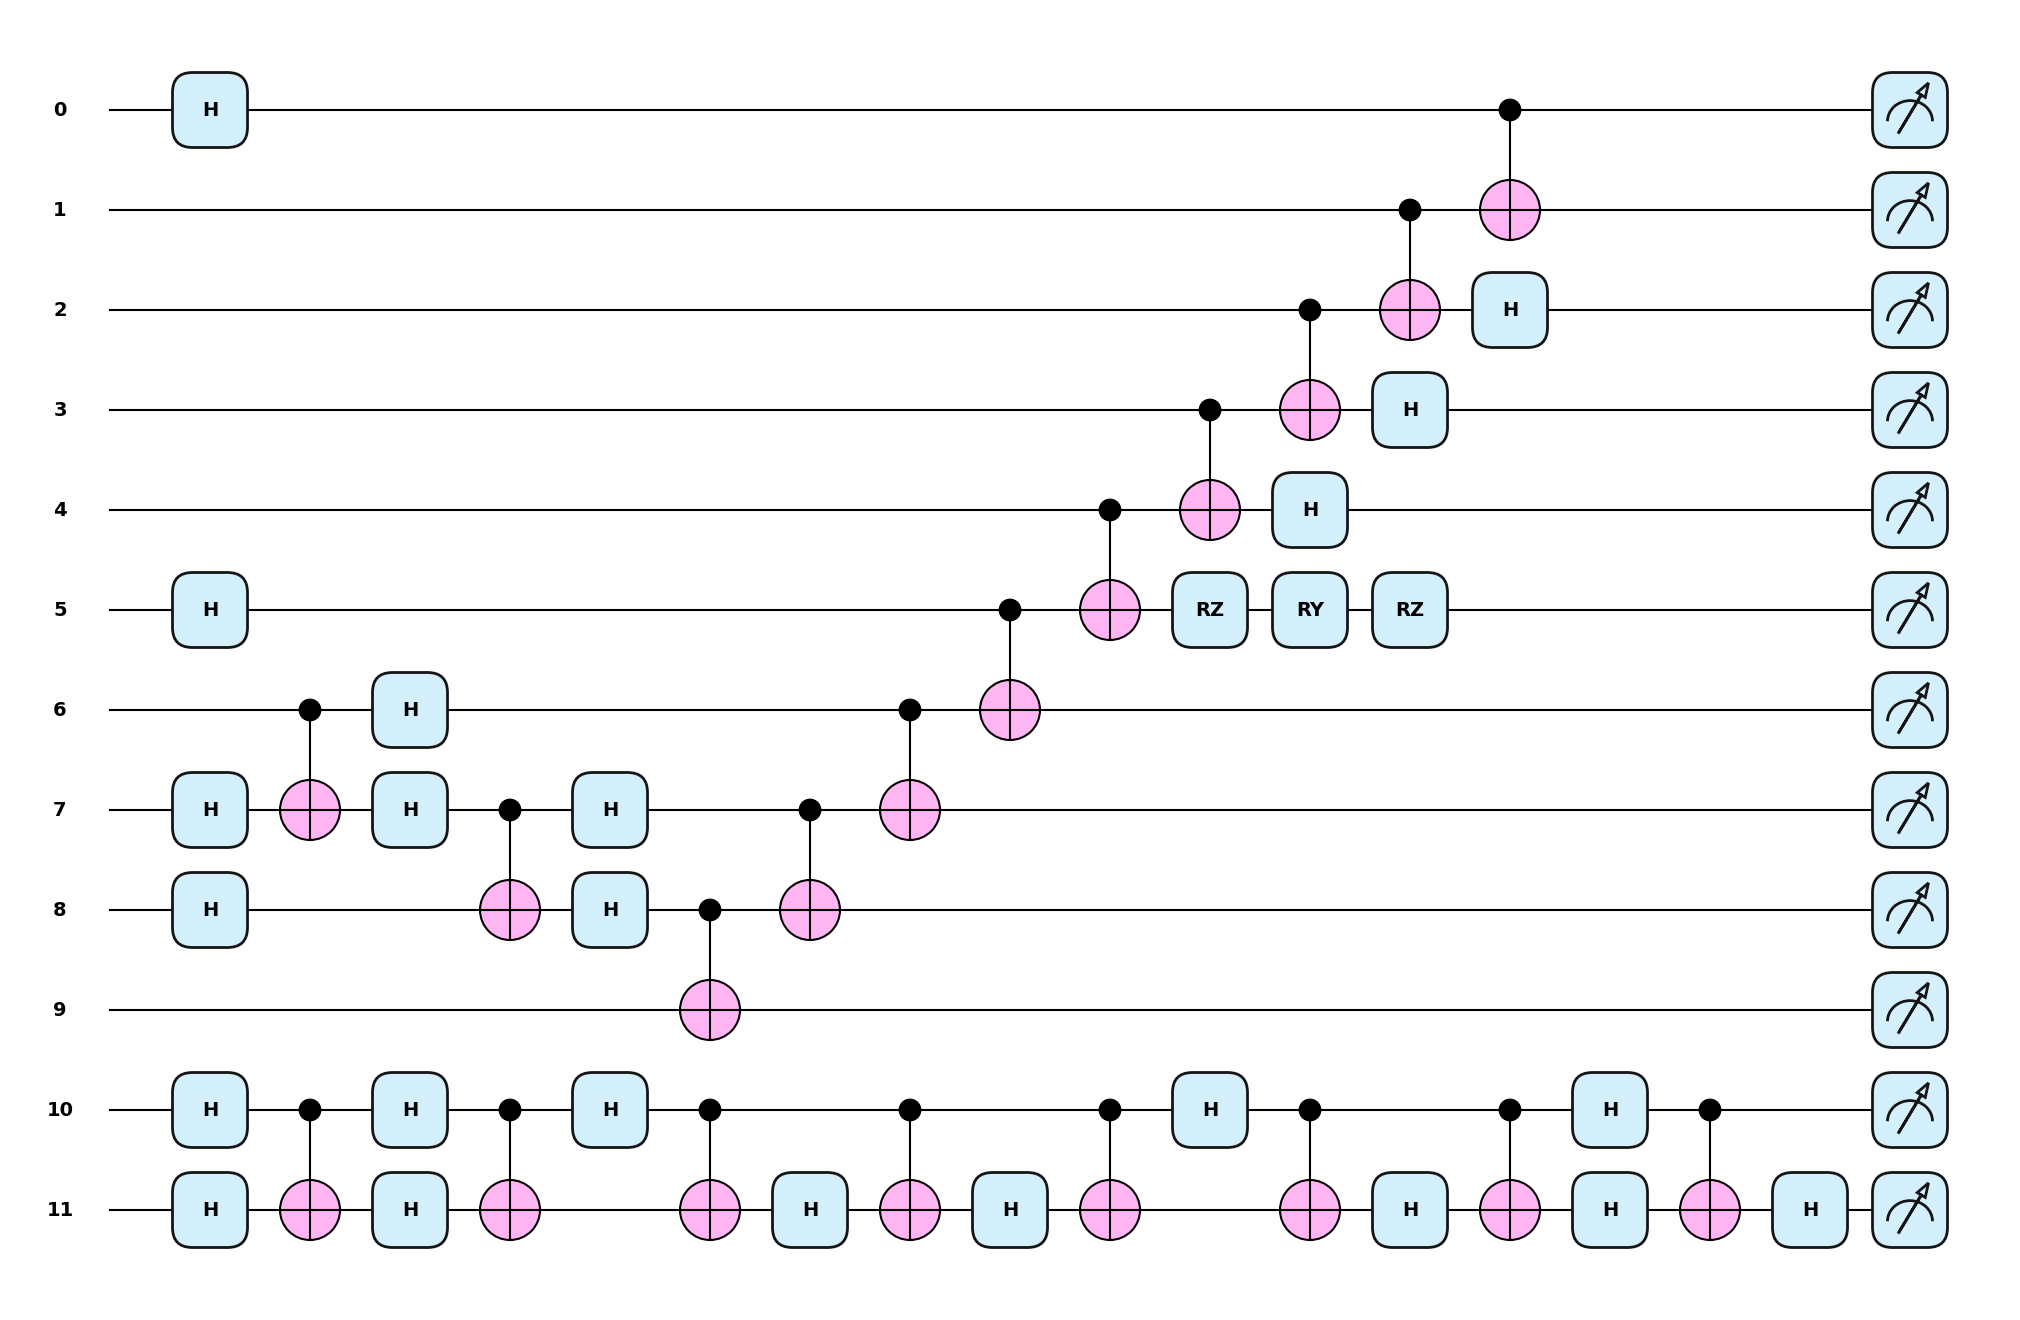

In [ ]:
# pennylane
compiled = qml.compile(circuit)

prev_gate_count = qml.specs(compiled)()['resources'].num_gates

cnt = 0
while cnt <=30:
    new_compiled = qml.compile(compiled)
    new_gate_count = qml.specs(new_compiled)()['resources'].num_gates

    if new_gate_count == prev_gate_count:
        compiled = new_compiled
        break

    compiled = new_compiled
    prev_gate_count = new_gate_count
    cnt += 1

print(cnt)
show_circuit(compiled)

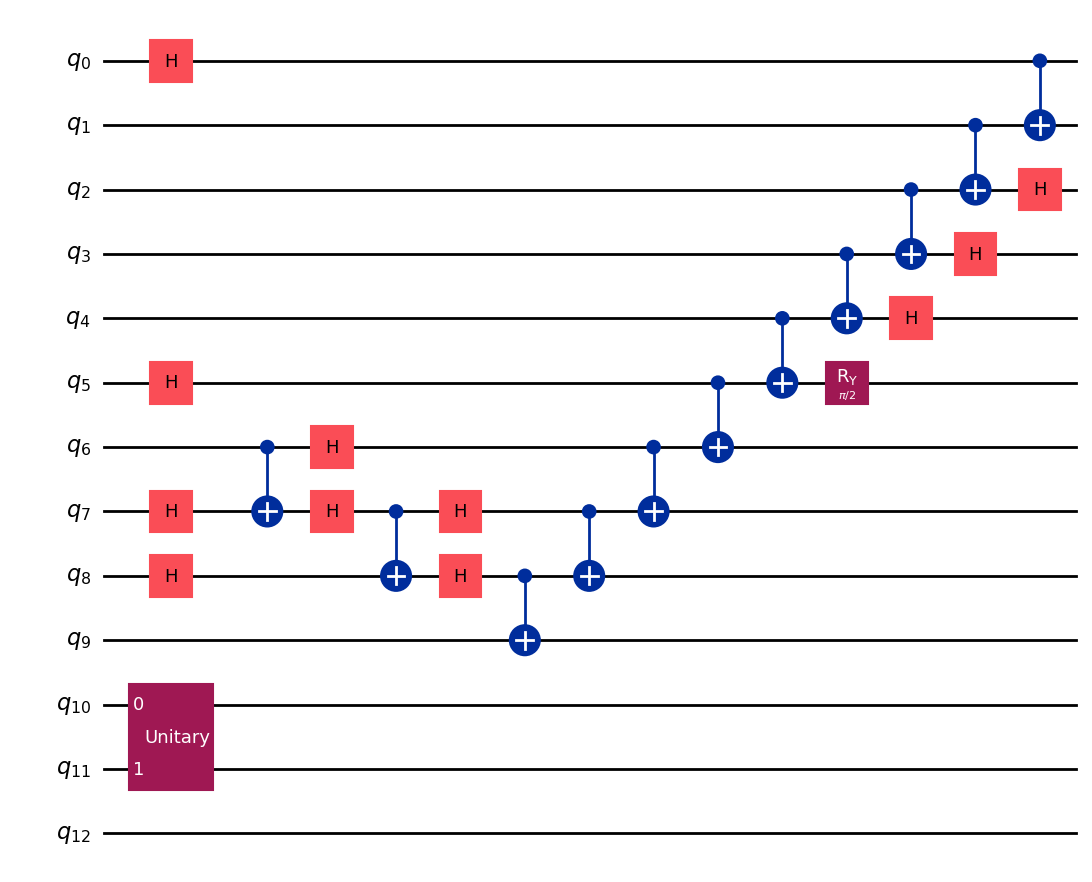

In [20]:
# qiskit
from qiskit_utils import to_qc
from qiskit import transpile as qiskit_transpiler
qc = qiskit_transpiler(to_qc(circuit), optimization_level=3)
qc.draw('mpl')

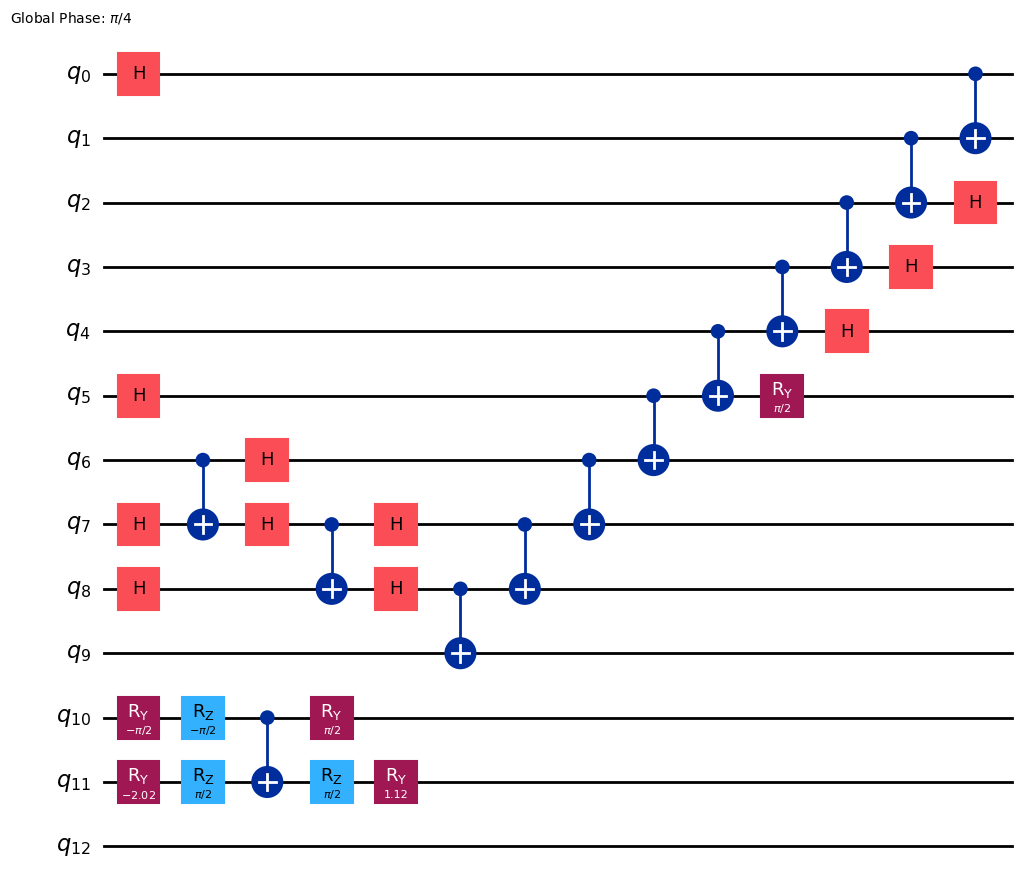

In [21]:
# qiskit
qc = qiskit_transpiler(to_qc(circuit),  basis_gates=["h","ry", "rz", "cx"], optimization_level=3)
qc.draw('mpl')

In [24]:
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import state_fidelity

# Strip measurements before extracting the statevector
qc_no_measure1 = to_qc(circuit).remove_final_measurements(inplace=False)
qc_no_measure2 = qc.remove_final_measurements(inplace=False)

# get statevectors
st1 = Statevector.from_instruction(qc_no_measure1)
st2 = Statevector.from_instruction(qc_no_measure2)

round(state_fidelity(st1, st2),3)

1.0

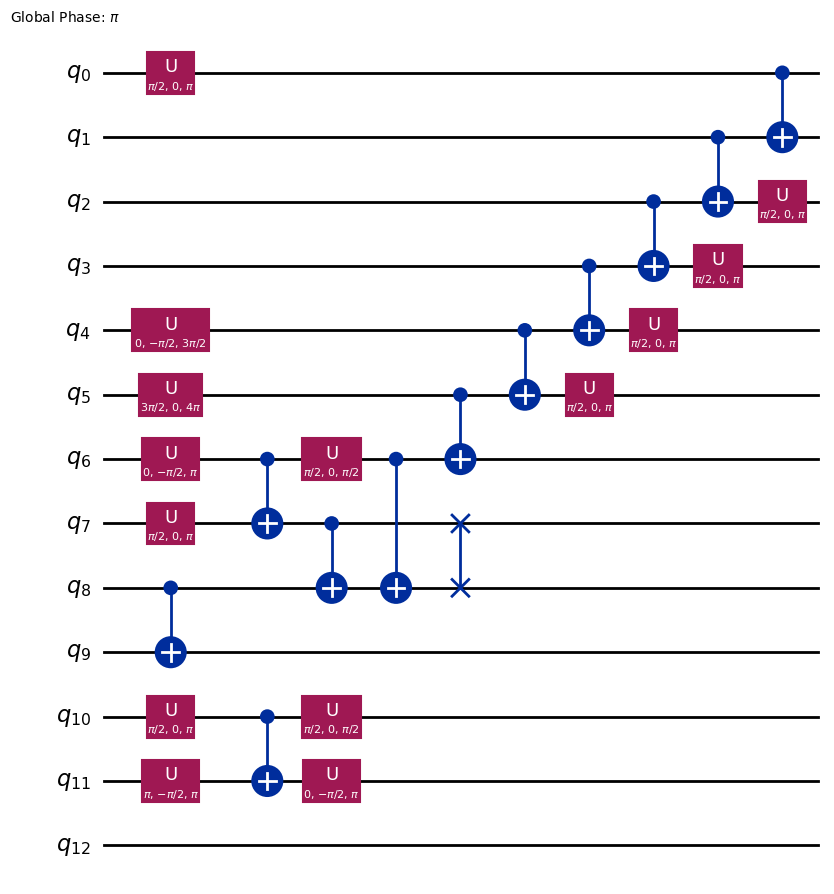

In [ ]:
from pytket import Circuit, OpType
from pytket.passes import FullPeepholeOptimise, RebaseCustom
from tket_loop import to_tket, tk_to_qiskit
from pytket.passes import FullPeepholeOptimise

circ = to_tket(circuit)
FullPeepholeOptimise().apply(circ) # inplace operation
circ.replace_implicit_wire_swaps()
qiskit_circ = tk_to_qiskit(circ)
qiskit_circ.draw("mpl")

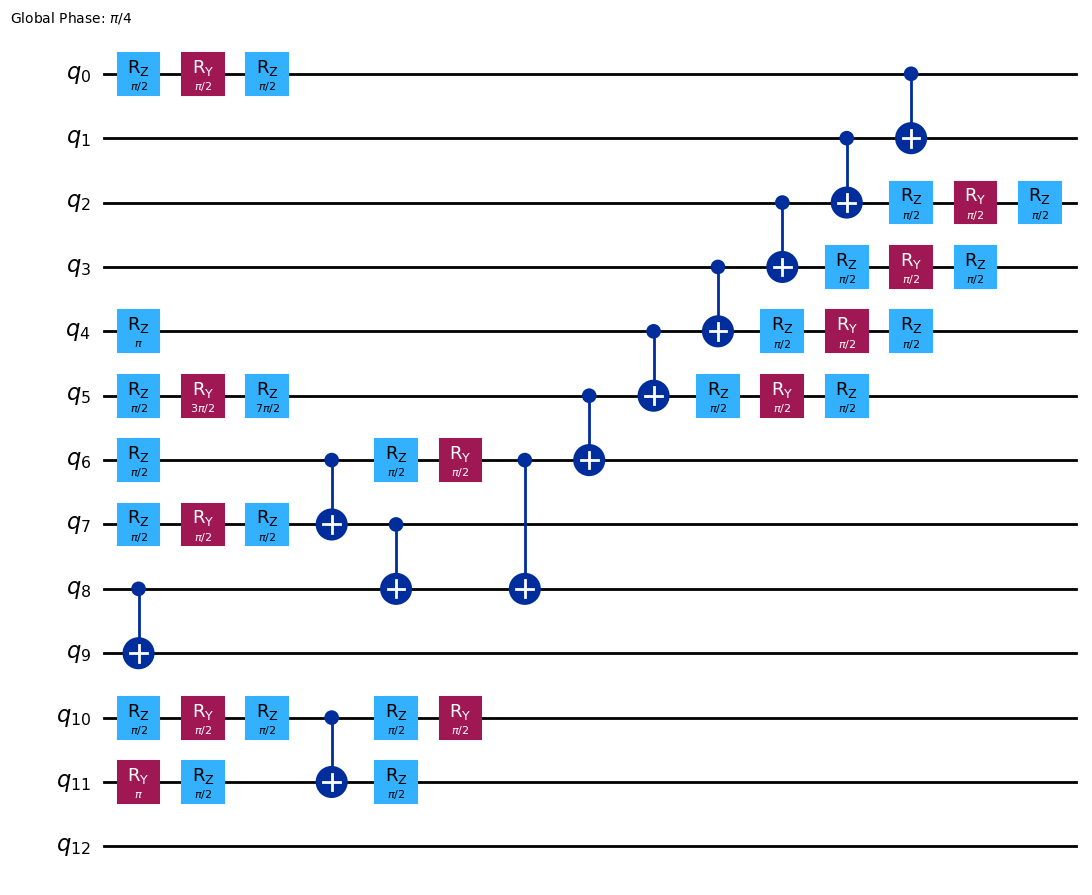

In [ ]:
circ = to_tket(circuit)

basis_set = {OpType.H, OpType.Ry, OpType.Rz, OpType.CX}
cx_replacement = Circuit(2).CX(0, 1)
FullPeepholeOptimise().apply(circ)
rebase_pass = RebaseCustom(basis_set, cx_replacement, tk1_to_rzryrz)
rebase_pass.apply(circ)

qiskit_circ = tk_to_qiskit(circ)
qiskit_circ.draw("mpl")


In [ ]:
from compare_sdk import comp_table, penny_specs
df = comp_table(circuit)
df['Mine'] = penny_specs(info_to_qnode(info7))
df

,Original,Qiskit,PennyLane,tket,Mine
Gate count,175,31,45,44,26
Single-qubit gate count,150,19,26,33,12
Two-qubit gate count,25,12,19,11,14
Circuit depth,58,14,17,15,15
